Load the "MainProcess.xes" file

In [2]:
import os
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import pandas as pd

# Directory with your .xes files
xes_directory = os.path.join(os.getcwd(), "20130794", "Cleaned Event Log")

# Output directory for models or visuals
output_directory = os.path.join(os.getcwd(), "output")
os.makedirs(output_directory, exist_ok=True)

# Process MainProcess.xes file
filename = "MainProcess.xes"
file_path = os.path.join(xes_directory, filename)
print(f"Processing {filename}")

try:
    log = xes_importer.apply(file_path)
    print("\n\n")
    print(f"Imported {filename} with {len(log)} traces.")
    
    # Print important information about the log
    print(f"Number of events: {sum(len(trace) for trace in log)}")
    activities = set(event["concept:name"] for trace in log for event in trace if "concept:name" in event)
    print(f"Number of unique activities: {len(activities)}")
    print(f"Unique activities: {activities}")
    case_ids = [trace.attributes["concept:name"] for trace in log if "concept:name" in trace.attributes]
    print(f"Number of cases: {len(case_ids)}")
    print(f"First 5 case IDs: {case_ids[:5]}")
    print("\n\n")

except Exception as e:
    print(f"Error processing {filename}: {e}")


Processing MainProcess.xes


c:\Users\olive\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 301/301 [00:00<00:00, 685.42it/s]




Imported MainProcess.xes with 301 traces.
Number of events: 9471
Number of unique activities: 21
Unique activities: {'/mm/drill', '/mm/deburr', '/vgr/pick_up_and_transport', '/dm/drill', '/hbw/store', '/dm/lower', '/dm/cylindrical_drill', '/hbw/get_empty_bucket', '/pm/punch_recesses', '/pm/punch_gill', '/hbw/unload', '/sm/transport', '/mm/transport_from_to', '/ov/temper', '/wt/pick_up_and_transport', '/hbw/store_empty_bucket', '/ov/burn', '/mm/mill', '/pm/punch_ribbing', '/sm/sort', '/hw/human_review'}
Number of cases: 301
First 5 case IDs: ['WF_101_0', 'WF_102_0', 'WF_103_0', 'WF_104_0', 'WF_105_0']





Get all the attributes included in this file ("MainProcess.xes")

In [3]:
try:
    # List all attributes of the traces in a table
    print("\n\nAttributes of traces:\n")
    
    trace_attributes = set()
    for trace in log:
        trace_attributes.update(trace.attributes.keys())
        
    trace_attr_info = []
    for attr in trace_attributes:
        attr_type = "unknown"
        for trace in log:
            if attr in trace.attributes:
                attr_type = type(trace.attributes[attr]).__name__
                break
        trace_attr_info.append({"Attribute": attr, "Type": attr_type})

    trace_attr_df = pd.DataFrame(trace_attr_info)
    display(trace_attr_df)
    # Save the attribute DataFrame to an Excel file in a "tables" subfolder
    tables_dir = os.path.join(os.getcwd(), "tables")
    os.makedirs(tables_dir, exist_ok=True)
    trace_attr_df.to_excel(os.path.join(tables_dir, "main_trace_attribute_info.xlsx"), index=False)
    
    # List all attributes of the events in a table
    print("\n\nAttributes of events:\n")
    
    event_attributes = set()
    for trace in log:
        for event in trace:
            event_attributes.update(event.keys())

    event_attr_info = []
    for attr in event_attributes:
        attr_type = "unknown"
        for trace in log:
            for event in trace:
                if attr in event:
                    attr_type = type(event[attr]).__name__
                    break
            if attr_type != "unknown":
                break
        event_attr_info.append({"Attribute": attr, "Type": attr_type})

    event_attr_df = pd.DataFrame(event_attr_info)
    display(event_attr_df)
    # Save the attribute DataFrame to an Excel file in a "tables" subfolder
    tables_dir = os.path.join(os.getcwd(), "tables")
    os.makedirs(tables_dir, exist_ok=True)
    event_attr_df.to_excel(os.path.join(tables_dir, "main_event_attribute_info.xlsx"), index=False)
except Exception as e:
    print(f"Error processing the log: {e}")




Attributes of traces:



,Attribute,Type
0,concept:name,str




Attributes of events:



,Attribute,Type
0,lifecycle:transition,str
1,SubProcessID,str
2,response_status_code,float
3,event_id,str
4,concept:name,str
5,process_model_id,str
6,current_task,str
7,operation_end_time,datetime
8,case,str
9,complete_service_time,str


List all the resources of the log in a table

In [4]:
try:
    # Set pandas display options for full width
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', 0)
    pd.set_option('display.max_columns', None)

    resources = set()
    for trace in log:
        for event in trace:
            if "org:resource" in event:
                resources.add(event["org:resource"])

    resource_info = []
    for resource in resources:
        # Find the first SubProcessID for this resource by searching events until found
        first_subprocess_id = "N/A"
        parameters_dict = None
        found = False
        for trace in log:
                for event in trace:
                    if event.get("org:resource") == resource:
                        if "SubProcessID" in event:
                            first_subprocess_id = event["SubProcessID"]
                            found = True
                            break
                if found:
                    break
                
        found = False
        for trace in log:
                for event in trace:
                    if event.get("org:resource") == resource:
                        if "parameters" in event:
                            parameters_dict = event["parameters"]
                            found = True
                            break
                if found:
                    break
        event_count = sum(1 for trace in log for event in trace if event.get("org:resource") == resource)
        activities_performed = set(event["concept:name"] for trace in log for event in trace if event.get("org:resource") == resource)
        
        resource_info.append({
            "Resource": resource,
            "Event Count": event_count,
            "Unique Activities": len(activities_performed),
            "Activities": ", ".join(sorted(activities_performed)),
        })

    resource_df = pd.DataFrame(resource_info)
    display(resource_df)
    # Save the attribute DataFrame to an Excel file in a "tables" subfolder
    tables_dir = os.path.join(os.getcwd(), "tables")
    os.makedirs(tables_dir, exist_ok=True)
    resource_df.to_excel(os.path.join(tables_dir, "resources_info.xlsx"), index=False)

except Exception as e:
    print(f"Error processing the log: {e}")

,Resource,Event Count,Unique Activities,Activities
0,vgr_1,1866,1,/vgr/pick_up_and_transport
1,sm_1,378,2,"/sm/sort, /sm/transport"
2,ov_1,612,2,"/ov/burn, /ov/temper"
3,hbw_1,873,4,"/hbw/get_empty_bucket, /hbw/store, /hbw/store_empty_bucket, /hbw/unload"
4,mm_2,381,4,"/mm/deburr, /mm/drill, /mm/mill, /mm/transport_from_to"
5,hbw_2,1581,2,"/hbw/store_empty_bucket, /hbw/unload"
6,mm_1,576,4,"/mm/deburr, /mm/drill, /mm/mill, /mm/transport_from_to"
7,dm_2,177,3,"/dm/cylindrical_drill, /dm/drill, /dm/lower"
8,vgr_2,885,1,/vgr/pick_up_and_transport
9,ov_2,330,1,/ov/burn


Load a single subevent log file

In [5]:


# Process 0a0a7c16-85d9-48be-a7d5-32931240c337.xes file
filename = "0a0a7c16-85d9-48be-a7d5-32931240c337.xes"
file_path = os.path.join(xes_directory, filename)
print(f"Processing {filename}")

try:
    subevent_log = xes_importer.apply(file_path)
    print("\n\n")
    print(f"Imported {filename} with {len(subevent_log)} traces.")

    # Print important information about the subevent_log
    print(f"Number of events: {sum(len(trace) for trace in subevent_log)}")
    activities = set(event["concept:name"] for trace in subevent_log for event in trace if "concept:name" in event)
    print(f"Number of unique activities: {len(activities)}")
    print(f"Unique activities: {activities}")
    case_ids = [trace.attributes["concept:name"] for trace in subevent_log if "concept:name" in trace.attributes]
    print(f"Number of cases: {len(case_ids)}")
    print(f"First 5 case IDs: {case_ids[:5]}")
    print("\n\n")

except Exception as e:
    print(f"Error processing {filename}: {e}")

Processing 0a0a7c16-85d9-48be-a7d5-32931240c337.xes


parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 141.40it/s]




Imported 0a0a7c16-85d9-48be-a7d5-32931240c337.xes with 1 traces.
Number of events: 5
Number of unique activities: 5
Unique activities: {'milling the workpiece', 'transporting the workpiece to the mill', 'ejecting the workpiece to the conveyor belt', 'transporting the workpiece to the ejection position', 'transporting the workpiece to the sorting machine'}
Number of cases: 0
First 5 case IDs: []





List all the attributes in this file

In [6]:
try:
    # List all attributes in the subevent_log in a table and display nicely in Jupyter Notebook
    all_attributes = set()
    for trace in subevent_log:
        all_attributes.update(trace.attributes.keys())
        for event in trace:
            all_attributes.update(event.keys())

    # Prepare attribute type information
    attr_info = []
    for attr in all_attributes:
        if attr in subevent_log[0].attributes:
            attr_type = type(subevent_log[0].attributes[attr]).__name__
        elif len(subevent_log[0]) > 0 and attr in subevent_log[0][0]:
            attr_type = type(subevent_log[0][0][attr]).__name__
        else:
            attr_type = "unknown"
        attr_info.append({"Attribute": attr, "Type": attr_type})

    # Display as a pandas DataFrame
    attr_df = pd.DataFrame(attr_info)
    display(attr_df)
    # Save the attribute DataFrame to an Excel file in a "tables" subfolder
    tables_dir = os.path.join(os.getcwd(), "tables")
    os.makedirs(tables_dir, exist_ok=True)
    attr_df.to_excel(os.path.join(tables_dir, "sub_attribute_info.xlsx"), index=False)

except Exception as e:
    print(f"Error processing the subevent_log: {e}")

,Attribute,Type
0,SubProcessID,str
1,stream:datastream,dict
2,operation_end_time,datetime
3,concept:name,str
4,time:timestamp,datetime
5,org:resource,str


Load the database file with the sensor data and query it using DuckDB

In [7]:
import duckdb
import os
from pathlib import Path
import pandas as pd


# Make sure xes_directory is defined before this line
parquet_dir = os.path.join(xes_directory, "parquet")

# Connect to an in-memory DuckDB instance
con = duckdb.connect(database=':memory:')

# Collect all .parquet files in the directory
parquet_file = os.path.join(parquet_dir, "all_combined_new.parquet")

# Ensure there are files to process
if not os.path.exists(parquet_file):
    raise FileNotFoundError(f"No Parquet file found at {parquet_file}")

# Register all Parquet files as a single virtual table (view)
# IMPORTANT: DuckDB's parquet_scan expects a *list of strings* to be passed as a DuckDB list literal
# Use array syntax ['file1.parquet', 'file2.parquet', ...]
parquet_list_str = f"'{parquet_file}'"
query = f"CREATE VIEW sensor_data AS SELECT * FROM parquet_scan([{parquet_list_str}])"
con.execute(query)

# Print the number of rows in the sensor_data table
if False:
    row_count = con.execute("SELECT COUNT(*) FROM sensor_data").fetchone()[0]
    print(f"Number of rows in sensor_data: {row_count}")

# Print column names
if False:
    info_df = con.execute("PRAGMA table_info('sensor_data')").df()
    print("\nColumns and types in sensor_data:")
    print(info_df['name'])

# Show a sample of the data
if False:
    print("\nSample rows from sensor_data:")
    sample_df = con.execute("SELECT * FROM sensor_data LIMIT 5").df()
    display(sample_df)


# ------------------------
# Enter query here
# ------------------------

df_sensor_grouped = con.execute("""
    SELECT 
        *
    FROM 
        sensor_data
    WHERE "org:resource" = 'pm_1'
    LIMIT 1
""").df()

# ------------------------


# Display with full width

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
display(df_sensor_grouped)




,trace:SubProcessID,concept:name,org:resource,time:timestamp,operation_end_time,stream:datastream,stream:system,stream:system_type,stream:observation,stream:procedure_type,stream:interaction_type,stream:timestamp,stream:value,sensor_key
0,02d2094a-7ffa-4a52-9c91-5fcd55593308,transporting the workpiece to the punch,pm_1,2021-06-23T15:48:58.201000,2021-06-23T15:49:44.201000,<NA>,http://iot.uni-trier.de/FTOnto#PM_1,sosa:Sensor,http://iot.uni-trier.de/StreamDataAnnotationOnto#PM_1_Property_Current_State,stream:discrete,sosa:Observation,2021-06-23T15:48:58.201000,not ready,stream:point


Number of processes per resource

In [8]:
df_sensor_grouped = con.execute("""
    SELECT 
        "org:resource",
        count(*) AS observation_count,
        SUM(data_points_count) AS total_data_points
        
    FROM 
        (SELECT 
            "org:resource",
            "trace:SubProcessID",
            count(*) AS data_points_count
        FROM sensor_data
        GROUP BY "org:resource", "trace:SubProcessID", 
        )
    GROUP BY "org:resource"
""").df()

# ------------------------


# Display with full width

pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
display(df_sensor_grouped)

,org:resource,observation_count,total_data_points
0,hbw_2,506,1833662.0
1,sm_1,119,6239204.0
2,ov_1,197,513777.0
3,wt_2,110,235296.0
4,hw_1,170,194413.0
5,hbw_1,275,54117983.0
6,vgr_2,293,847392.0
7,mm_1,189,7454870.0
8,ov_2,110,147497.0
9,sm_2,103,115255.0


Analyse some example process from MainProcess file

In [9]:
# Process MainProcess.xes file
filename = "MainProcess.xes"
file_path = os.path.join(xes_directory, filename)
print(f"Processing {filename}")

try:
    log = xes_importer.apply(file_path)
    print("\n\n")
    print(f"Imported {filename} with {len(log)} traces.")
    
    
    # Display only the concept:name attribute of the events in the first trace
    if len(log) > 0:
        first_trace = log[0]
        print(f"First trace case ID: {first_trace.attributes.get('concept:name', 'N/A')}")
        for idx, event in enumerate(first_trace):
            print(f"Event {idx+1}: concept:name = {event.get('concept:name', 'N/A')}, SubProcessID = {event.get('SubProcessID', 'N/A')}")
    else:
        print("Log is empty, no traces to display.")

    print("\n---\n")
    
    first_subprocess_id = "27958fc0-4484-41ff-9260-e76f8a83a7cd"
    file = first_subprocess_id + ".xes"
    file_path = os.path.join(xes_directory, file)
    
    print(f"Processing subprocess file: {file}")

    sub_log = xes_importer.apply(file_path)
    print(f"Imported {file} with {len(sub_log)} traces.")

    # Display only the concept:name attribute of the events in the first trace of the subprocess log
    if len(sub_log) > 0:
        first_sub_trace = sub_log[0]
        for idx, event in enumerate(first_sub_trace):
            print(f"Event {idx+1}: concept:name = {event.get('concept:name', 'N/A')}, org:resource = {event.get('org:resource', 'N/A')}")
    else:
        print("Subprocess log is empty, no traces to display.")

except Exception as e:
    print(f"Error processing {filename}: {e}")

Processing MainProcess.xes


parsing log, completed traces :: 100%|██████████| 301/301 [00:00<00:00, 675.05it/s]





Imported MainProcess.xes with 301 traces.
First trace case ID: WF_101_0
Event 1: concept:name = /hbw/unload, SubProcessID = N/A
Event 2: concept:name = /hbw/unload, SubProcessID = 27958fc0-4484-41ff-9260-e76f8a83a7cd
Event 3: concept:name = /hbw/unload, SubProcessID = N/A
Event 4: concept:name = /vgr/pick_up_and_transport, SubProcessID = N/A
Event 5: concept:name = /vgr/pick_up_and_transport, SubProcessID = 4d198444-6633-4218-b1f7-ca67ec666360
Event 6: concept:name = /vgr/pick_up_and_transport, SubProcessID = N/A
Event 7: concept:name = /hbw/store_empty_bucket, SubProcessID = N/A
Event 8: concept:name = /hbw/store_empty_bucket, SubProcessID = e73aa303-98af-407e-be4e-5ebdee33bc4d
Event 9: concept:name = /hbw/store_empty_bucket, SubProcessID = N/A
Event 10: concept:name = /vgr/pick_up_and_transport, SubProcessID = N/A
Event 11: concept:name = /vgr/pick_up_and_transport, SubProcessID = 0e7b5a4c-4c03-47b2-96fd-e401ed7fbca9
Event 12: concept:name = /vgr/pick_up_and_transport, SubProcessI

parsing log, completed traces :: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s]

Imported 27958fc0-4484-41ff-9260-e76f8a83a7cd.xes with 1 traces.
Event 1: concept:name = moving towards the slot 0, org:resource = hbw_2
Event 2: concept:name = picking up the bucket from the slot, org:resource = hbw_2
Event 3: concept:name = transporting the bucket to the conveyor belt, org:resource = hbw_2
Event 4: concept:name = dropping off the bucket at the conveyor belt, org:resource = hbw_2
Event 5: concept:name = transporting the bucket to the vacuum gripper robot crane jib, org:resource = hbw_2


Analyze Subprocess Data

In [10]:
df_sensor_grouped = con.execute("""
    SELECT 
        *
    FROM sensor_data
    WHERE "org:resource" = 'ov_1'
    AND "concept:name" = 'transporting the workpiece to the inside of the oven'
    AND "trace:SubProcessID" = '001618a4-1be3-406c-bd83-ebe5cff5e4f7'
    
""").df()

grouped = df_sensor_grouped.groupby(['stream:system', 'stream:observation'])

for name, group in grouped:
    proc_type = group['stream:procedure_type'].iloc[0]
    print(f"\nGroup: {name}")
    if proc_type == 'stream:continuous':
        # Convert stream:value to numeric if possible
        vals = pd.to_numeric(group['stream:value'], errors='coerce')
        min_val = vals.min()
        max_val = vals.max()
        print(f"  stream:procedure_type = stream:continuous, range: [{min_val}, {max_val}]")
    else:
        unique_vals = group['stream:value'].unique()
        print(f"  stream:procedure_type = {proc_type}, values: {unique_vals}")
        


Group: ('http://iot.uni-trier.de/FTOnto#OV_1', 'http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Temperature')
  stream:procedure_type = stream:continuous, range: [25.427, 25.427]

Group: ('http://iot.uni-trier.de/FTOnto#OV_1', 'http://iot.uni-trier.de/StreamDataAnnotationOnto#OV_1_Property_Current_State')
  stream:procedure_type = stream:discrete, values: ['not ready']

Group: ('http://iot.uni-trier.de/FTOnto#OV_1', 'http://iot.uni-trier.de/StreamDataAnnotationOnto#OV_1_Property_Current_Task_Elapsed_Seconds_Since_Start')
  stream:procedure_type = stream:continuous, range: [3.031237, 5.53083]

Group: ('http://iot.uni-trier.de/FTOnto#OV_1_Light_Barrier_5', 'http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted')
  stream:procedure_type = stream:binary, values: ['1.0' '0.0']

Group: ('http://iot.uni-trier.de/FTOnto#OV_1_Motor_1', 'http://iot.uni-trier.de/FTOnto#MotorSpeed')
  stream:procedure_type = stream:continuous, range: [-512.0, -512.0]

Group: ('http://iot.uni-trier.de/FTOnto#OV_1_Positi

In [11]:
df_sensor_grouped = con.execute("""
    SELECT 
        *
    FROM sensor_data
    WHERE "org:resource" = 'pm_1'
    AND "concept:name" = 'transporting the workpiece to the punch'
    
""").df()

grouped = df_sensor_grouped.groupby(['stream:system', 'stream:observation'])

for name, group in grouped:
    proc_type = group['stream:procedure_type'].iloc[0]
    print(f"\nGroup: {name}")
    if proc_type == 'stream:continuous':
        # Convert stream:value to numeric if possible
        vals = pd.to_numeric(group['stream:value'], errors='coerce')
        min_val = vals.min()
        max_val = vals.max()
        print(f"  stream:procedure_type = stream:continuous, range: [{min_val}, {max_val}]")
    else:
        unique_vals = group['stream:value'].unique()
        print(f"  stream:procedure_type = {proc_type}, values: {unique_vals}")


Group: ('http://iot.uni-trier.de/FTOnto#PM_1', 'http://iot.uni-trier.de/StreamDataAnnotationOnto#PM_1_Property_Current_State')
  stream:procedure_type = stream:discrete, values: ['not ready']

Group: ('http://iot.uni-trier.de/FTOnto#PM_1', 'http://iot.uni-trier.de/StreamDataAnnotationOnto#PM_1_Property_Current_Task_Elapsed_Seconds_Since_Start')
  stream:procedure_type = stream:continuous, range: [0.093731, 124.781221]

Group: ('http://iot.uni-trier.de/FTOnto#PM_1_Capacitive_Sensor_6', 'http://iot.uni-trier.de/FTOnto#Electric_Field_Changed')
  stream:procedure_type = stream:binary, values: ['0.0' '1.0']

Group: ('http://iot.uni-trier.de/FTOnto#PM_1_Capacitive_Sensor_7', 'http://iot.uni-trier.de/FTOnto#Electric_Field_Changed')
  stream:procedure_type = stream:binary, values: ['0.0' '1.0']

Group: ('http://iot.uni-trier.de/FTOnto#PM_1_Capacitive_Sensor_8', 'http://iot.uni-trier.de/FTOnto#Electric_Field_Changed')
  stream:procedure_type = stream:binary, values: ['1.0']

Group: ('http://io

In [12]:
import networkx as nx
from collections import Counter
import math

df_sensor_grouped = con.execute("""
    SELECT 
        "trace:SubProcessID", "time:timestamp", "concept:name"
    FROM sensor_data
    WHERE "org:resource" = 'hbw_2'
      AND "concept:name" NOT ILIKE 'calibrating%'
    GROUP BY "trace:SubProcessID", "time:timestamp", "concept:name"
""").df()

# Group by SubProcessID and collect event names in order
subprocess_groups = df_sensor_grouped.groupby('trace:SubProcessID')

events = []

for sub_id, group in subprocess_groups:
    # Sort by timestamp and get event names
    event_names = group.sort_values('time:timestamp')['concept:name'].tolist()
    # Remove consecutive duplicates
    for i in range(1, len(event_names)):
        if event_names[i] != event_names[i-1] and (event_names[i-1], event_names[i]) not in events:
            events.append((event_names[i-1], event_names[i]))

            
# Print all the directly-follows relations
print(f"Total unique directly-follows relations: {len(events)}")
num_concept_names = df_sensor_grouped['concept:name'].nunique()
print(f"Number of unique concept:name values: {num_concept_names}")
print("Directly-follows relations (event1 -> event2):")
for e1, e2 in events:
    print(f"  {e1} -> {e2}")
    



Total unique directly-follows relations: 38
Number of unique concept:name values: 26
Directly-follows relations (event1 -> event2):
  moving towards the slot 6 -> picking up the bucket from the slot
  picking up the bucket from the slot -> transporting the bucket to the conveyor belt
  transporting the bucket to the conveyor belt -> dropping off the bucket at the conveyor belt
  dropping off the bucket at the conveyor belt -> transporting the bucket to the vacuum gripper robot crane jib
  transporting the bucket to the high-bay warehouse crane jib -> transporting the bucket to the high bay warehouse crane jib
  transporting the bucket to the high bay warehouse crane jib -> picking up the bucket from the conveyor belt
  picking up the bucket from the conveyor belt -> transporting the bucket to the slot 5
  transporting the bucket to the slot 5 -> dropping off the bucket at the slot
  moving towards the slot 3 -> picking up the bucket from the slot
  moving towards the slot 5 -> picking 

Data analysis for synthetic data

In [13]:
import numpy as np

df_sensor_grouped = con.execute("""
    SELECT 
    "stream:observation",
    "stream:system",
    "stream:value",
    "stream:timestamp"
    FROM sensor_data
    WHERE "org:resource" = 'vgr_2' AND "stream:procedure_type" = 'stream:continuous'
    GROUP BY "stream:observation", "stream:system", "org:resource", "stream:procedure_type", "stream:value", "stream:timestamp"
    
""").df()

# Convert stream:value to numeric where possible and keep original DF intact
df_with_num = df_sensor_grouped.copy()
df_with_num['_num_val'] = pd.to_numeric(df_with_num['stream:value'], errors='coerce')

# Aggregate numeric ranges per observation
range_df = df_with_num.groupby('stream:observation').agg(
    min_value = ('_num_val', 'min'),
    max_value = ('_num_val', 'max'),
    numeric_count = ('_num_val', lambda s: s.notna().sum()),
    total_count = ('_num_val', 'size')
).reset_index()

# Add convenience columns and sort by range width
range_df['has_numeric'] = range_df['numeric_count'] > 0
range_df['range_width'] = range_df.apply(
    lambda r: (r['max_value'] - r['min_value']) if r['has_numeric'] else None, axis=1
)
range_df = range_df.sort_values(by='range_width', ascending=False)

# Display results
display(range_df[['stream:observation', 'min_value', 'max_value', 'range_width', 'numeric_count', 'total_count', 'has_numeric']])



,stream:observation,min_value,max_value,range_width,numeric_count,total_count,has_numeric
1,http://iot.uni-trier.de/FTOnto#MotorSpeed,-512.00,512.000000,1024.000000,158832,158832,True
0,http://iot.uni-trier.de/FTOnto#CompressorPowerLevel,0.00,512.000000,512.000000,52944,52944,True
2,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Current_Position_X,-66.85,327.310000,394.160000,52944,52944,True
5,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Target_Position_X,20.89,327.310000,306.420000,52944,52944,True
4,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Current_Position_Z,-0.45,135.070000,135.520000,52944,52944,True
7,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Target_Position_Z,0.00,135.070000,135.070000,52944,52944,True
3,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Current_Position_Y,-0.45,125.920000,126.370000,52944,52944,True
6,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Crane_Jib_Property_Target_Position_Y,0.00,126.070000,126.070000,52944,52944,True
8,http://iot.uni-trier.de/StreamDataAnnotationOnto#VGR_2_Property_Current_Task_Elapsed_Seconds_Since_Start,0.00,47.202877,47.202877,52944,52944,True


Synthetic data can be added in: ov_1, mm_1, sm_1, wt_1, vgr_1, 

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


,range,count
0,-80 to -75,26
1,-75 to -70,236
2,-70 to -65,164
3,-65 to -60,118
4,-60 to -55,142
5,-55 to -50,111
6,-50 to -45,106
7,-45 to -40,49
8,-40 to -35,88
9,-35 to -30,126


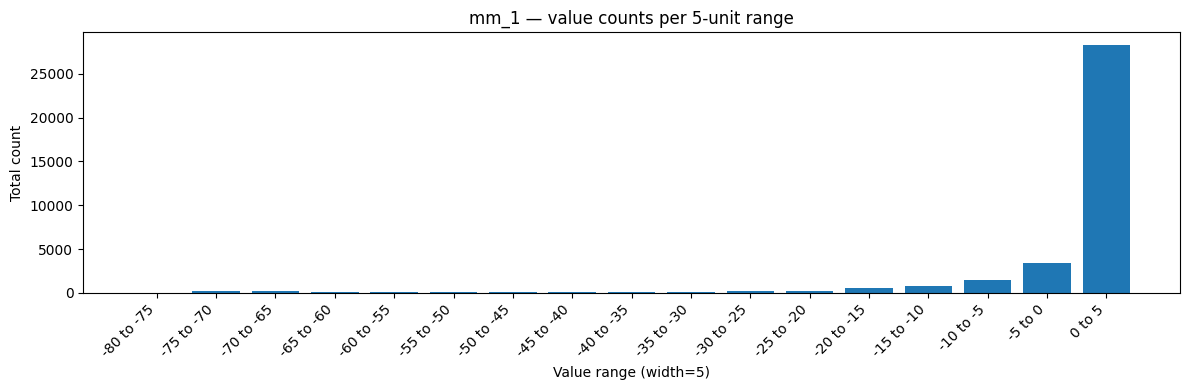

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()


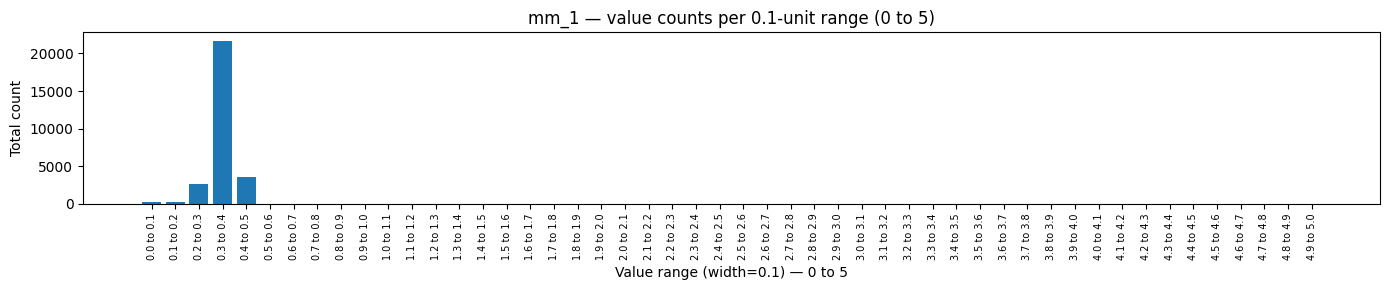

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


,range,count
0,-20 to -15,34
1,-15 to -10,136
2,-10 to -5,44
3,-5 to 0,2
4,0 to 5,117993
5,5 to 10,21


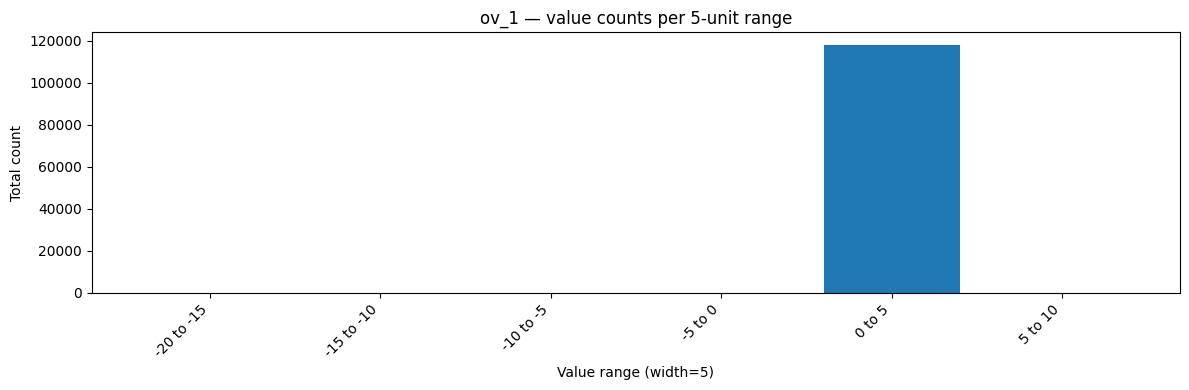

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()


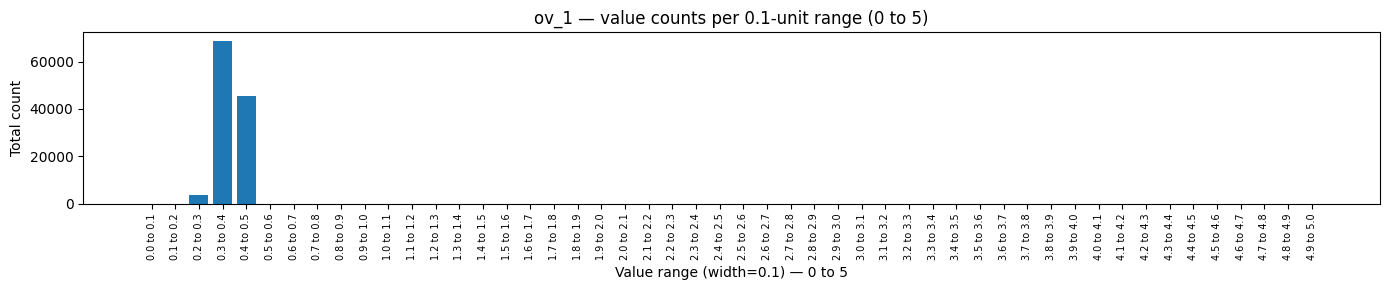

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


,range,count
0,0 to 5,34663
1,5 to 10,49
2,10 to 15,195
3,15 to 20,79
4,20 to 25,17
5,25 to 30,9
6,30 to 35,11
7,35 to 40,11
8,40 to 45,16
9,45 to 50,14


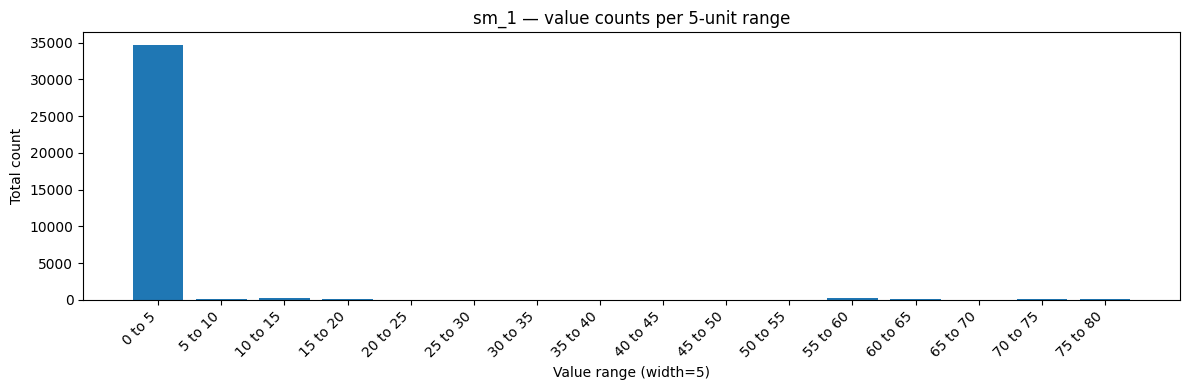

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()


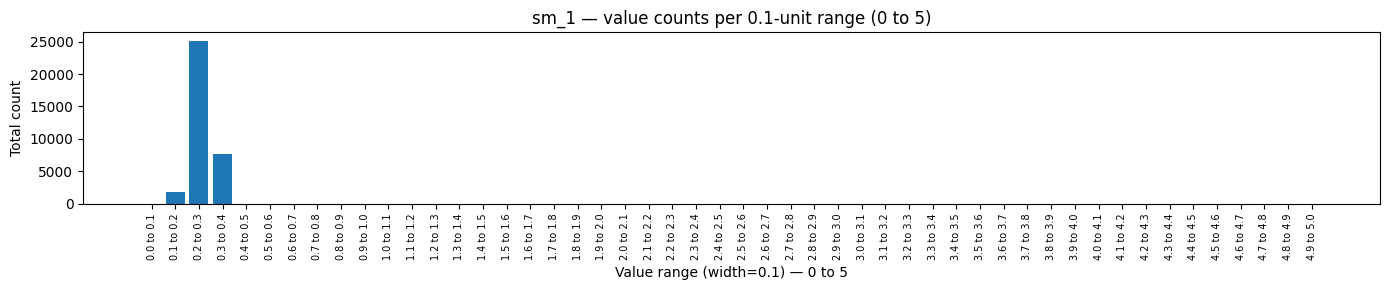

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


,range,count
0,-35 to -30,23
1,-30 to -25,61315
2,-25 to -20,70010
3,-20 to -15,26594
4,-15 to -10,1925
5,-10 to -5,863
6,-5 to 0,970
7,0 to 5,156932
8,5 to 10,21


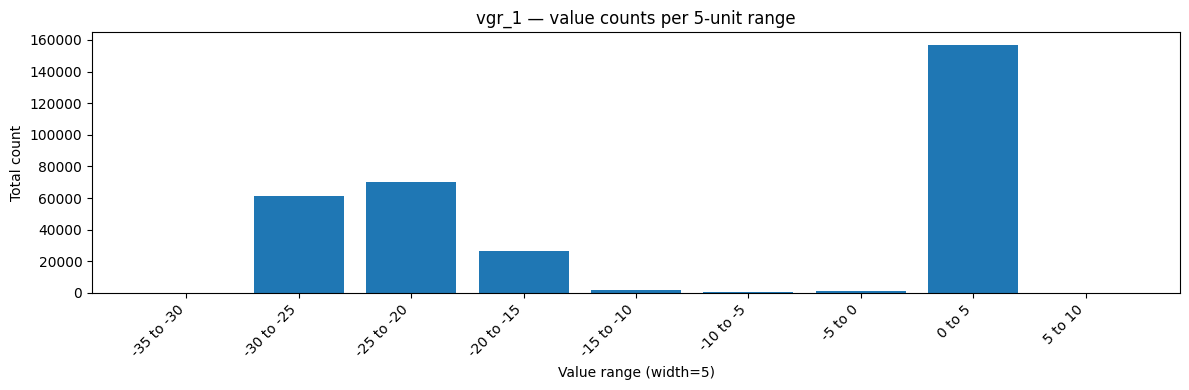

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()


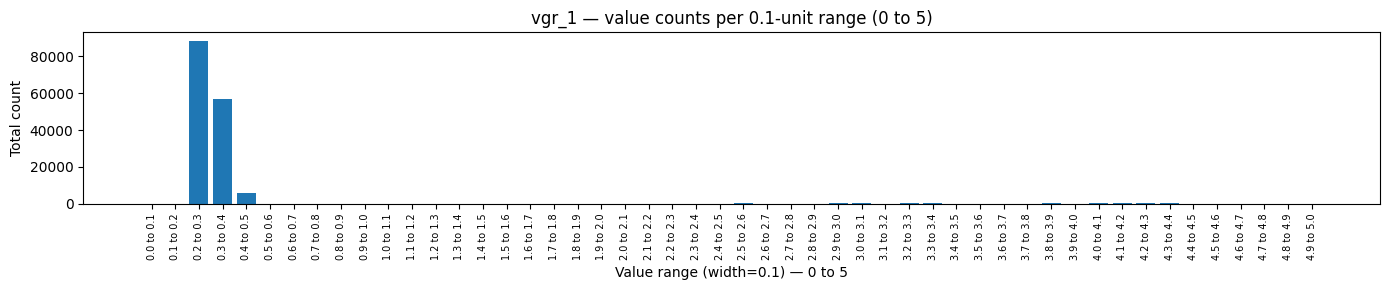

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


,range,count
0,-25 to -20,4
1,-20 to -15,9139
2,-15 to -10,14024
3,-10 to -5,5828
4,-5 to 0,253
5,0 to 5,33513
6,5 to 10,2259


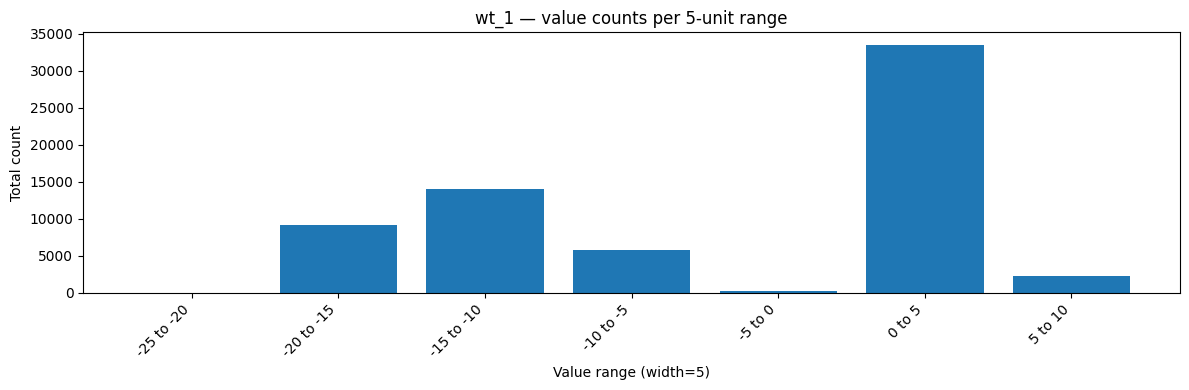

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3620700067.py:65: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()


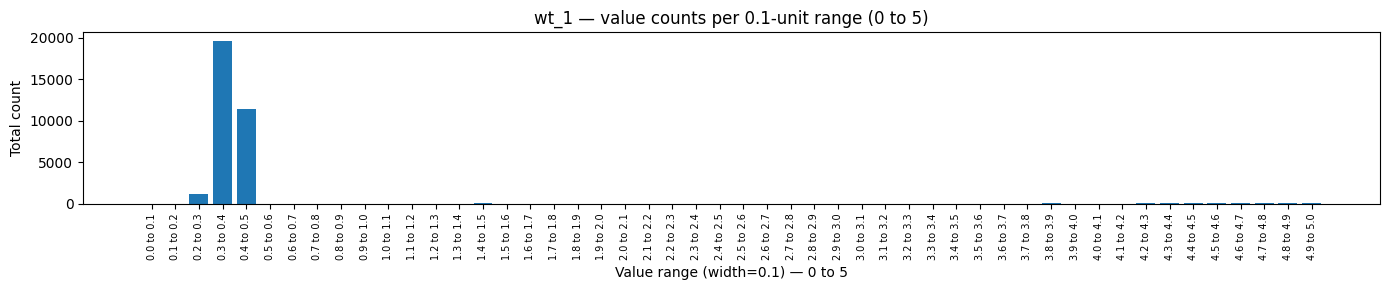

In [14]:
# Add freqency count for values for each of the given resources

df_sensor_grouped = con.execute("""
    SELECT 
        "org:resource",
        "stream:observation",
        "stream:system",
        "stream:value",
        COUNT(*) AS value_count
    FROM sensor_data
    WHERE "org:resource" IN ('ov_1', 'mm_1', 'sm_1', 'wt_1', 'vgr_1')
      AND "stream:procedure_type" = 'stream:continuous'
      AND "stream:observation" ILIKE '%Pressure%'
    GROUP BY "org:resource", "stream:observation", "stream:system", "stream:value"
    ORDER BY "org:resource", "stream:observation", value_count DESC
""").df()

import matplotlib.pyplot as plt


resources = df_sensor_grouped['org:resource'].unique()

for res in resources:
    res_df = df_sensor_grouped[df_sensor_grouped['org:resource'] == res]
    # Group values into uniform-width ranges (width=5) and count occurrences using the aggregated value_count
    res_df = res_df.copy()
    res_df['_num'] = pd.to_numeric(res_df['stream:value'], errors='coerce')
    res_df = res_df.dropna(subset=['_num'])

    if res_df.empty:
        print(f"No numeric values for resource {res}")
    else:
        width = 5
        start = math.floor(res_df['_num'].min() / width) * width
        stop = math.ceil(res_df['_num'].max() / width) * width
        bins = np.arange(start, stop + width, width)
        labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]
        res_df['range'] = pd.cut(res_df['_num'], bins=bins, labels=labels, include_lowest=True, right=False)
        range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()
        range_counts.columns = ['range', 'count']
        
        display(range_counts)
        
        # Plot
        plt.figure(figsize=(12,4))
        plt.bar(range_counts['range'].astype(str), range_counts['count'])
        plt.xticks(rotation=45, ha='right')
        plt.xlabel(f"Value range (width={width})")
        plt.ylabel("Total count")
        plt.title(f"{res} — value counts per {width}-unit range")
        plt.tight_layout()
        plt.show()
        
        # For the range of 0 to 5, give another plot with finer granularity (width=0.1)
        # finer granularity for 0 to 5 (width=0.1)
        subset_zero = res_df[(res_df['_num'] >= 0) & (res_df['_num'] <= 5)].copy()
        if subset_zero.empty:
            print(f"No values in [0,5] for resource {res}")
        else:
            width_fine = 0.1
            bins_fine = np.arange(0, 5 + width_fine, width_fine)
            labels_fine = [f"{bins_fine[i]:.1f} to {bins_fine[i+1]:.1f}" for i in range(len(bins_fine) - 1)]

            subset_zero['range_fine'] = pd.cut(subset_zero['_num'], bins=bins_fine, labels=labels_fine, include_lowest=True, right=False)
            fine_counts = subset_zero.groupby('range_fine')['value_count'].sum().reindex(labels_fine, fill_value=0).reset_index()
            fine_counts.columns = ['range_fine', 'count']

            plt.figure(figsize=(14,3))
            plt.bar(fine_counts['range_fine'].astype(str), fine_counts['count'], width=0.8)
            plt.xticks(rotation=90, fontsize=7)
            plt.xlabel(f"Value range (width={width_fine}) — 0 to 5")
            plt.ylabel("Total count")
            plt.title(f"{res} — value counts per {width_fine}-unit range (0 to 5)")
            plt.tight_layout()
            plt.show()

Test the synthetic data

,org:resource,stream:observation,stream:system,stream:value,value_count
0,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,1.7459000000000007,4826
1,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,1.4630200000000007,1869
2,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,1.7846100000000003,1829
3,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,1.6688750000000006,1223
4,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,1.8829200000000006,1186
...,...,...,...,...,...
64768,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,-30.70897200000001,1
64769,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,31.599435000000014,1
64770,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,-96.077984,1
64771,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,63.80902500000001,1


,org:resource,stream:observation,stream:system,stream:value,value_count
0,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,0.395,14649
1,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,0.331,7075
2,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,0.426,3519
3,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,0.268,2013
4,mm_1,http://iot.uni-trier.de/FTOnto#MM_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#MM_1_Compressor_8,0.237,631
...,...,...,...,...,...
2761,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,1.247,1
2762,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,9.295,1
2763,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,8.348,1
2764,wt_1,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8,8.916,1


C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3494190921.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


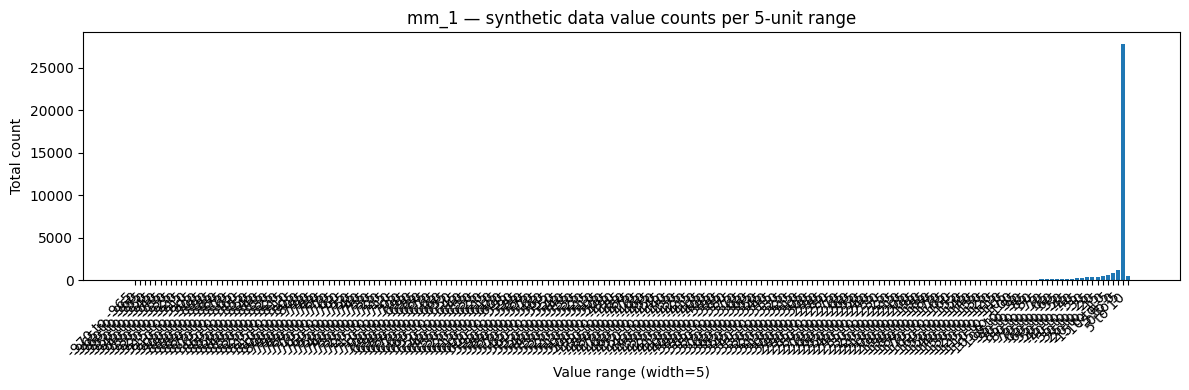

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3494190921.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


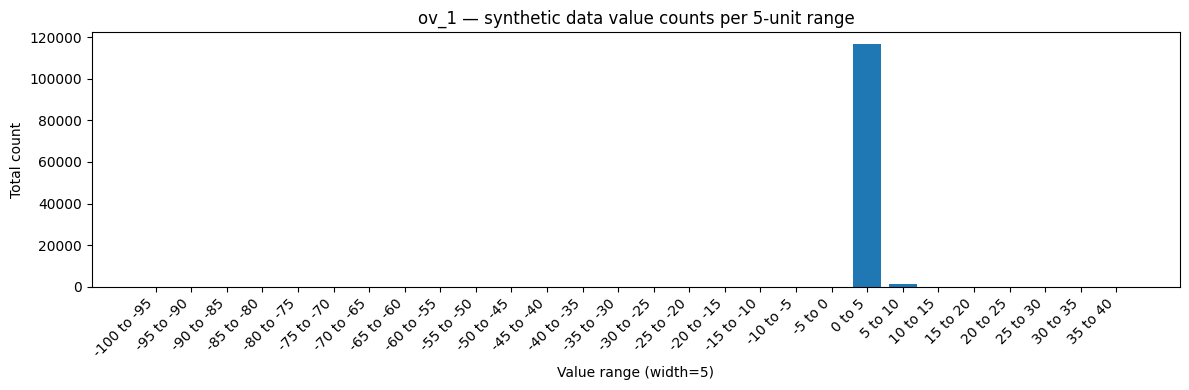

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3494190921.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


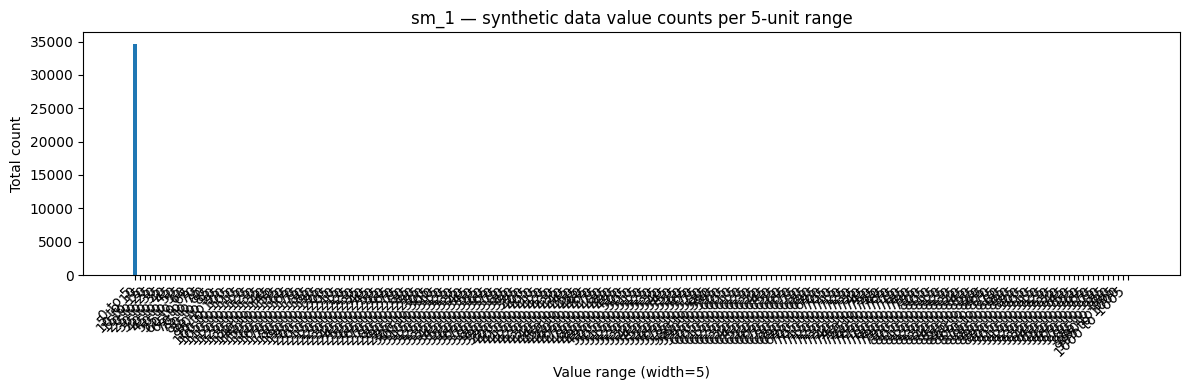

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3494190921.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


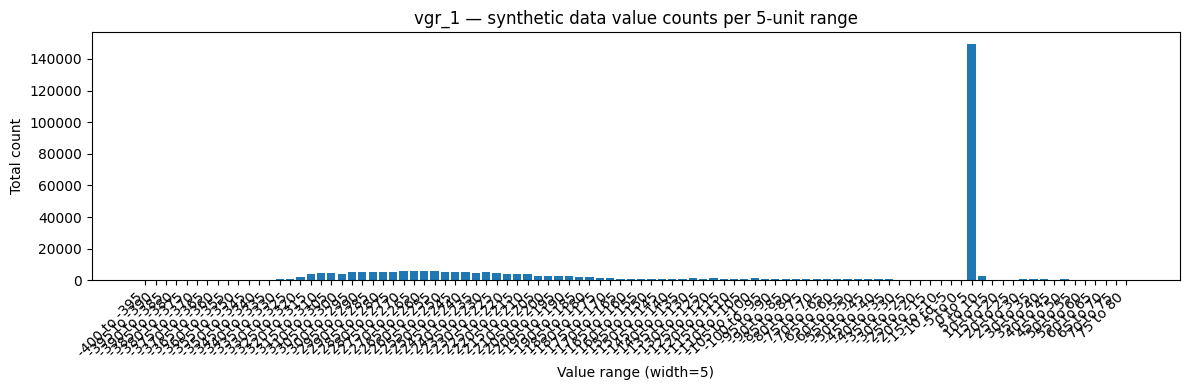

C:\Users\olive\AppData\Local\Temp\ipykernel_25172\3494190921.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()


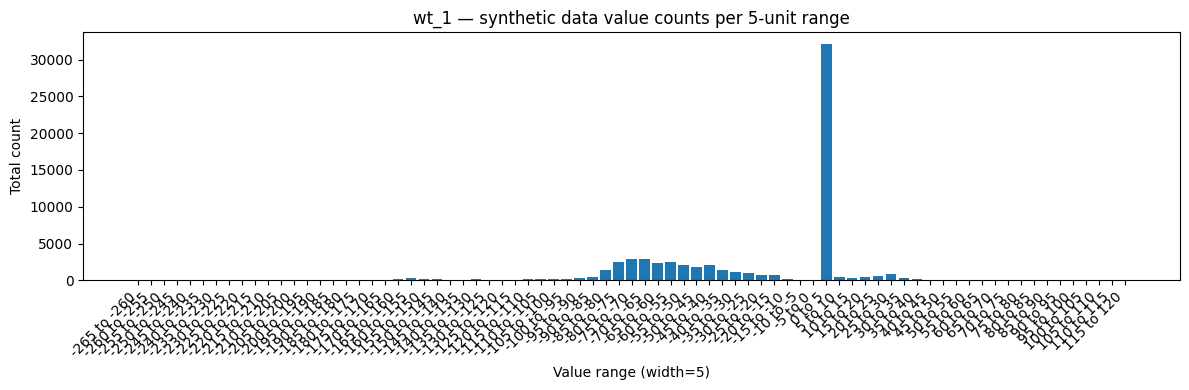

In [15]:
# Create a DuckDB connection for the synthetic dataset
con_synthetic = duckdb.connect(database=":memory:")

parquet_file = os.path.join(parquet_dir, "all_combined_with_synthetic.parquet")

if not os.path.exists(parquet_file):
  raise FileNotFoundError(f"No Parquet file found at {parquet_file}")

parquet_list_str = f"'{parquet_file}'"
con_synthetic.execute(f"CREATE OR REPLACE VIEW synthetic_sensor_data AS SELECT * FROM parquet_scan([{parquet_list_str}])")

df_synthetic_data = con_synthetic.execute("""
    SELECT 
        "org:resource",
        "stream:observation",
        "stream:system",
        "stream:value",
        COUNT(*) AS value_count
    FROM synthetic_sensor_data
    WHERE "org:resource" IN ('ov_1', 'mm_1', 'sm_1', 'wt_1', 'vgr_1')
      AND "stream:procedure_type" = 'stream:continuous'
      AND "stream:observation" ILIKE '%Pressure%'
    GROUP BY "org:resource", "stream:observation", "stream:system", "stream:value"
    ORDER BY "org:resource", "stream:observation", value_count DESC
""").df()

display(df_synthetic_data)
display(df_sensor_grouped)


# for synthetic data dataframe display how often values occur
df_sensor_grouped = con_synthetic.execute("""
    SELECT 
        "org:resource",
        "stream:observation",
        "stream:system",
        "stream:value",
        COUNT(*) AS value_count
    FROM synthetic_sensor_data
    WHERE "org:resource" IN ('ov_1', 'mm_1', 'sm_1', 'wt_1', 'vgr_1')
      AND "stream:procedure_type" = 'stream:continuous'
      AND "stream:observation" ILIKE '%Pressure%'
    GROUP BY "org:resource", "stream:observation", "stream:system", "stream:value"
    ORDER BY "org:resource", "stream:observation", value_count DESC
""").df()

resources = df_sensor_grouped['org:resource'].unique()

for res in resources:
  res_df = df_sensor_grouped[df_sensor_grouped['org:resource'] == res]
  res_df = res_df.copy()
  res_df['_num'] = pd.to_numeric(res_df['stream:value'], errors='coerce')
  res_df = res_df.dropna(subset=['_num'])

  if res_df.empty:
    print(f"No numeric values for resource {res}")
  else:
    width = 5
    start = math.floor(res_df['_num'].min() / width) * width
    stop = math.ceil(res_df['_num'].max() / width) * width
    bins = np.arange(start, stop + width, width)
    labels = [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]
    res_df['range'] = pd.cut(res_df['_num'], bins=bins, labels=labels, include_lowest=True, right=False)
    range_counts = res_df.groupby('range')['value_count'].sum().reindex(labels, fill_value=0).reset_index()
    range_counts.columns = ['range', 'count']
    plt.figure(figsize=(12,4))
    plt.bar(range_counts['range'].astype(str), range_counts['count'])
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(f"Value range (width={width})")
    plt.ylabel("Total count")
    plt.title(f"{res} — synthetic data value counts per {width}-unit range")
    plt.tight_layout()
    plt.show()


Find als sensors with discrete values

In [16]:
df_synthetic_data = con_synthetic.execute("""
    SELECT 
        "stream:observation",
        COUNT(*) AS value_count
    FROM synthetic_sensor_data
    WHERE "stream:procedure_type" = 'stream:discrete'
    GROUP BY "stream:observation", "stream:procedure_type"
    ORDER BY value_count
""").df()

display(df_synthetic_data)

,stream:observation,value_count
0,http://iot.uni-trier.de/StreamDataAnnotationOnto#DM_2_Property_Current_State,5768
1,http://iot.uni-trier.de/StreamDataAnnotationOnto#SM_2_Property_Current_State,8192
2,http://iot.uni-trier.de/StreamDataAnnotationOnto#MM_2_Property_Current_State,8211
3,http://iot.uni-trier.de/StreamDataAnnotationOnto#PM_1_Property_Current_State,9291
4,http://iot.uni-trier.de/StreamDataAnnotationOnto#SM_1_Property_Current_State,10180
5,http://iot.uni-trier.de/StreamDataAnnotationOnto#MM_1_Property_Current_State,10704
6,http://iot.uni-trier.de/StreamDataAnnotationOnto#OV_2_Property_Current_State,18246
7,None,18372
8,http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_2_Property_Current_State,29412
9,http://iot.uni-trier.de/StreamDataAnnotationOnto#OV_1_Property_Current_State,34509


Check the amount of nan values per resource

In [17]:
df_synthetic_data = con_synthetic.execute("""
    SELECT 
        "org:resource",
        "stream:value",
        "stream:observation",
        "stream:system",
        COUNT(*) AS value_count
    FROM synthetic_sensor_data
    WHERE "stream:value" IS NULL
       OR lower(trim("stream:value")) IN ('none', 'nan', 'null', '')
    GROUP BY "org:resource", "stream:value", "stream:observation", "stream:system"
    ORDER BY value_count
""").df()

df = con_synthetic.execute("""
    SELECT 
        "org:resource",
        "stream:observation",
        "stream:system",
        COUNT(*) AS value_count
    FROM synthetic_sensor_data
    WHERE "stream:observation" = 'http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted'
        AND "org:resource" IN ('pm_1', 'dm_2')
    GROUP BY "org:resource", "stream:observation", "stream:system"
    ORDER BY value_count
""").df()

display(df_synthetic_data)
display(df)

,org:resource,stream:value,stream:observation,stream:system,value_count
0,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_1,222
1,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_2,719
2,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_3,919
3,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Waiting_Platform,1018
4,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_4,1027
5,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_5,1134
6,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_6,1201
7,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_7,1243
8,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_8,1280
9,hbw_1,None,http://iot.uni-trier.de/FTOnto#NFC_Tag_UID,http://iot.uni-trier.de/FTOnto#HBW_1_Slot_9,1291


,org:resource,stream:observation,stream:system,value_count
0,dm_2,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#DM_2_Light_Barrier_6,5768
1,dm_2,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#DM_2_Light_Barrier_7,5768
2,dm_2,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#DM_2_Light_Barrier_5,5768
3,dm_2,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#DM_2_Light_Barrier_4,5768
4,pm_1,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#PM_1_Light_Barrier_5,9291
5,pm_1,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#PM_1_Light_Barrier_4,9291
6,pm_1,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#PM_1_Light_Barrier_7,9291
7,pm_1,http://iot.uni-trier.de/FTOnto#LightBarrierInterrupted,http://iot.uni-trier.de/FTOnto#PM_1_Light_Barrier_6,9291


Find synchronized sensors for a resource

In [18]:
# Find maximal sets of sensors whose timestamps are identical for all of their occurrences

df = con_synthetic.execute("""
    SELECT 
        "stream:timestamp",
        STRING_AGG(DISTINCT "stream:system" || ':' || "stream:observation", ', ' ORDER BY "stream:system" || ':' || "stream:observation") AS sensor_group,
        COUNT(DISTINCT "stream:system" || ':' || "stream:observation") AS num_sensors,
        COUNT(*) AS occurrence_count
    FROM (SELECT * FROM synthetic_sensor_data WHERE "org:resource" = 'wt_1' LIMIT 20000)
    GROUP BY "stream:timestamp"
    ORDER BY occurrence_count DESC
""").df()

# Group by the sensor_group to see which combinations occur and how often
df_grouped = df.groupby('sensor_group').agg(
    timestamp_count=('stream:timestamp', 'count'),
    total_occurrences=('occurrence_count', 'sum'),
    num_sensors=('num_sensors', 'first')
).reset_index().sort_values('timestamp_count', ascending=False)

display(df_grouped)

,sensor_group,timestamp_count,total_occurrences,num_sensors
5,"http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#CompressorPowerLevel, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_State, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_Task_Elapsed_Seconds_Since_Start, http://iot.uni-trier.de/FTOnto#WT_1_Motor_2:http://iot.uni-trier.de/FTOnto#MotorSpeed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_3:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_4:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Valve_5:http://iot.uni-trier.de/FTOnto#ValveOpen, http://iot.uni-trier.de/FTOnto#WT_1_Valve_6:http://iot.uni-trier.de/FTOnto#ValveOpen",1942,15536,8
0,http://iot.uni-trier.de/FTOnto#OV_1:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Temperature,1788,1788,1
6,http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure,1785,1785,1
3,"http://iot.uni-trier.de/FTOnto#OV_1:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Temperature, http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure",286,572,2
4,"http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#CompressorPowerLevel, http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_State, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_Task_Elapsed_Seconds_Since_Start, http://iot.uni-trier.de/FTOnto#WT_1_Motor_2:http://iot.uni-trier.de/FTOnto#MotorSpeed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_3:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_4:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Valve_5:http://iot.uni-trier.de/FTOnto#ValveOpen, http://iot.uni-trier.de/FTOnto#WT_1_Valve_6:http://iot.uni-trier.de/FTOnto#ValveOpen",18,162,9
2,"http://iot.uni-trier.de/FTOnto#OV_1:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Temperature, http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#CompressorPowerLevel, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_State, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_Task_Elapsed_Seconds_Since_Start, http://iot.uni-trier.de/FTOnto#WT_1_Motor_2:http://iot.uni-trier.de/FTOnto#MotorSpeed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_3:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switch_4:http://iot.uni-trier.de/FTOnto#PositionSwitchPressed, http://iot.uni-trier.de/FTOnto#WT_1_Valve_5:http://iot.uni-trier.de/FTOnto#ValveOpen, http://iot.uni-trier.de/FTOnto#WT_1_Valve_6:http://iot.uni-trier.de/FTOnto#ValveOpen",14,126,9
1,"http://iot.uni-trier.de/FTOnto#OV_1:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Temperature, http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#CompressorPowerLevel, http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Compressor_8:http://iot.uni-trier.de/FTOnto#OV_1_WT_1_Pneumatic_System_Pressure, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_State, http://iot.uni-trier.de/FTOnto#WT_1:http://iot.uni-trier.de/StreamDataAnnotationOnto#WT_1_Property_Current_Task_Elapsed_Seconds_Since_Start, http://iot.uni-trier.de/FTOnto#WT_1_Motor_2:http://iot.uni-trier.de/FTOnto#MotorSpeed, http://iot.uni-trier.de/FTOnto#WT_1_Position_Switc

Get the form of all multidimensional sensor values (like position)

In [22]:
df = con_synthetic.execute("""
    SELECT 
        "stream:value",
        "stream:observation",
        "stream:system"
    FROM synthetic_sensor_data
    WHERE "stream:procedure_type" = 'stream:continuous'
    GROUP BY "stream:value", "stream:observation", "stream:system", "stream:procedure_type"
""").df()

# Filter to keep only non-numerical values
df['_num'] = pd.to_numeric(df['stream:value'], errors='coerce')
df = df[df['_num'].isna()].drop(columns=['_num'])

display(df)

,stream:value,stream:observation,stream:system
0,"[-28.6264, -1.9227, -30.1599]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Rotation,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_Gyroscope_1
1,"[-0.7499, -10.1522, 0.4711]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Acceleration,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_AccSensor_1
3,"[2.3073, -16.4973, 1.8555]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Acceleration,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_AccSensor_1
4,"[-1.7305, -10.5848, -0.0192]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Acceleration,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_AccSensor_1
5,"[16.2664, -8.5223, -5.7375]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Rotation,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_Gyroscope_1
...,...,...,...
30795163,"[-2.4644, -2.823, -1.7167]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Rotation,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_Gyroscope_1
30795164,"[0.9037, -10.4021, -0.7306]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Acceleration,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_AccSensor_1
30795165,"[1.144, -9.5465, -0.0192]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Acceleration,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_AccSensor_1
30795166,"[-0.679, -2.5025, -0.5112]",http://iot.uni-trier.de/FTOnto#VGR_1_Crane_Jib_Rotation,http://iot.uni-trier.de/FTOnto#BMX055_Pi_1_Gyroscope_1
